In [1]:
# !pip install git+git://github.com/StochSS/sciope.git@master
import numpy as np
import sys
sys.path.insert(1, '/home/smatthe2/sciope')
sys.path.insert(1, '/home/smatthe2/GillesPy2')
import sciope
import gillespy2
import pickle
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver, SSACSolver, TauHybridCSolver

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
variables = {'juvenile_concentration': 0.49534348836011316,
             'birth_rate': 0.055,
             'maturity_rate': 0.04,
             'infection_rate_infected': 1e-05,
             'infection_rate_diseased': 3.84e-05,
             'incubation': 10.25,
             'progression': 10.74,
             'death_rate_juvenile': 0.007,
             'death_rate_susceptible': 0.02335,
             'death_rate_over_population': 2.3e-07,
             'death_rate_infected': 0.022609,
             'death_rate_diseased': .29017,
             'DFTD_start': 100}
variables_orig = variables.copy()
total_time = np.arange(0, 421, 1)

In [3]:
import pandas as pd

pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:])
init_devils_pop = devil_pop[0]

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
# print(obs)

In [4]:
class Devils2Stage(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_susceptible = Parameter(
            name="death_rate_susceptible", expression=values['death_rate_susceptible']
        )
        death_rate_over_population = Parameter(
            name="death_rate_over_population", expression=values['death_rate_over_population']
        )
        infection_rate_infected = Parameter(
            name="infection_rate_infected", expression=values['infection_rate_infected']
        )
        infection_rate_diseased = Parameter(
            name="infection_rate_diseased", expression=values['infection_rate_diseased']
        )
        incubation = Parameter(name="incubation", expression=values['incubation'])
        juvenile_concentration = Parameter(name="juvenile_concentration", expression=values['juvenile_concentration'])

        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        progression = Parameter(name="progression", expression=values['progression'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        DFTD_start = Parameter(name="DFTD_start", expression=values['DFTD_start'])
        
        self.add_parameter([birth_rate, death_rate_juvenile, maturity_rate, death_rate_susceptible, juvenile_concentration,
                            death_rate_over_population, infection_rate_infected, infection_rate_diseased,
                            incubation, death_rate_infected, progression, death_rate_diseased, DFTD_start])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", mode="discrete",
            initial_value=round(initial_devil_population * values['juvenile_concentration'])
        )
        Susceptible = Species(
            name="Susceptible", mode="discrete",
            initial_value=round(initial_devil_population * (1 - values['juvenile_concentration']))
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

                
        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased': 1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        self.add_reaction([
            Birth, Mature, Death_Diseased, Death_Diseased2, Death_Exposed, Death_Exposed2, Death_Infected,
            Death_Infected2, Death_Juvenile, Death_Juvenile2, Death_Susceptible, Death_Susceptible2,
            DFTD_Stage1, DFTD_Stage2, TransmissionD, TransmissionI
        ])

        # Events
        
        et = EventTrigger(expression='t>=DFTD_start')
        ea1 = EventAssignment(variable=Susceptible, expression='Susceptible-1')
        ea2 = EventAssignment(variable=Infected, expression='1')
        introduce_dftd = Event(name='introduce_dftd', trigger=et, assignments=[ea1, ea2])
        self.add_event(introduce_dftd)
        if events is not None:
            self.add_event(events)

        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan
        

In [5]:
model = Devils2Stage()

In [6]:
# take default from mode 1 as reference
default_param = np.array(list(model.listOfParameters.items()))[:, 1]

print(default_param)

parameter_names = []
bound = []
mat_ind = 100
for i,exp in enumerate(default_param):
    if exp.name=='maturity_rate':
        mat_ind = i
    bound.append(float(exp.expression))
    parameter_names.append(exp.name)

print(parameter_names)
print(bound)

# Set the bounds
bound = np.array(bound)
min_stand = bound * .75
max_stand = bound * 1.25
min_stand[mat_ind] = bound[mat_ind]
max_stand[mat_ind] = bound[mat_ind]

dmin = np.log(min_stand)
dmax = np.log(max_stand)


print(dmin)
print(dmax)

['DFTD_start', 'birth_rate', 'death_rate_diseased', 'death_rate_infected', 'death_rate_juvenile', 'death_rate_over_population', 'death_rate_susceptible', 'incubation', 'infection_rate_diseased', 'infection_rate_infected', 'juvenile_concentration', 'maturity_rate', 'progression']
[100.0, 0.055, 0.29017, 0.022609, 0.007, 2.3e-07, 0.02335, 10.25, 3.84e-05, 1e-05, 0.49534348836011316, 0.04, 10.74]
[  4.31748811  -3.18810417  -1.52497039  -4.07708929  -5.2495272
 -15.5728686   -4.04484037   2.03959563 -10.45513517 -11.80060754
  -0.99018591  -3.21887582   2.08629302]
[  4.82831374  -2.67727854  -1.01414477  -3.56626367  -4.73870158
 -15.06204298  -3.53401474   2.55042126  -9.94430955 -11.28978191
  -0.47936029  -3.21887582   2.59711864]


In [7]:
with open('abc_res_vanilla.p', 'rb') as res_obj_file:
    res = pickle.load(res_obj_file)

In [8]:
res

{'accepted_samples': [array([  4.80726697,  -2.82104761,  -1.06999939,  -4.01028471,
          -4.90928315, -15.57247459,  -3.6435396 ,   2.17101602,
         -10.09167101, -11.49990297,  -0.4931567 ,  -3.21887582,
           2.19424983]),
  array([  4.80726697,  -2.82104761,  -1.06999939,  -4.01028471,
          -4.90928315, -15.57247459,  -3.6435396 ,   2.17101602,
         -10.09167101, -11.49990297,  -0.4931567 ,  -3.21887582,
           2.19424983]),
  array([  4.47987262,  -2.87049593,  -1.49158785,  -3.63718944,
          -4.9293103 , -15.1258171 ,  -3.88472801,   2.05029813,
         -10.20274275, -11.58795158,  -0.84968471,  -3.21887582,
           2.10500703]),
  array([  4.62763451,  -2.91018555,  -1.29293375,  -3.93910169,
          -4.84963851, -15.3374203 ,  -3.77424321,   2.52119581,
          -9.99404632, -11.66282767,  -0.87671806,  -3.21887582,
           2.19210672]),
  array([  4.80726697,  -2.82104761,  -1.06999939,  -4.01028471,
          -4.90928315, -15.57247459

In [9]:
mae_inference = mean_absolute_error(bound, res['inferred_parameters'])

## Analysis

In [10]:
posterior = np.array(res['accepted_samples'])

In [11]:
print(posterior)

[[ 4.80726697 -2.82104761 -1.06999939 ... -0.4931567  -3.21887582
   2.19424983]
 [ 4.80726697 -2.82104761 -1.06999939 ... -0.4931567  -3.21887582
   2.19424983]
 [ 4.47987262 -2.87049593 -1.49158785 ... -0.84968471 -3.21887582
   2.10500703]
 ...
 [ 4.56951132 -2.89276642 -1.17913564 ... -0.91864463 -3.21887582
   2.45236916]
 [ 4.55285142 -2.90071396 -1.31394927 ... -0.65149565 -3.21887582
   2.53546721]
 [ 4.54169865 -2.72282853 -1.05028963 ... -0.68294105 -3.21887582
   2.57754993]]


Left to Right:
0: DFTD_start
1: birth_rate


<ipython-input-12-1378d3b21cbd>:15: UserWarning: Attempting to set identical left == right == 0.04000000000000001 results in singular transformations; automatically expanding.
  ax[i,j].set_xlim(np.exp(dmin[j]), np.exp(dmax[j]))


2: death_rate_diseased
3: death_rate_infected
4: death_rate_juvenile
5: death_rate_over_population
6: death_rate_susceptible
7: incubation
8: infection_rate_diseased
9: infection_rate_infected
10: juvenile_concentration
11: maturity_rate
12: progression


<ipython-input-12-1378d3b21cbd>:11: UserWarning: Attempting to set identical left == right == 0.04000000000000001 results in singular transformations; automatically expanding.
  ax[i,j].set_xlim(np.exp(dmin[i]), np.exp(dmax[i]))
<ipython-input-12-1378d3b21cbd>:14: UserWarning: Attempting to set identical bottom == top == 0.04000000000000001 results in singular transformations; automatically expanding.
  ax[i,j].set_ylim(np.exp(dmin[i]), np.exp(dmax[i]))


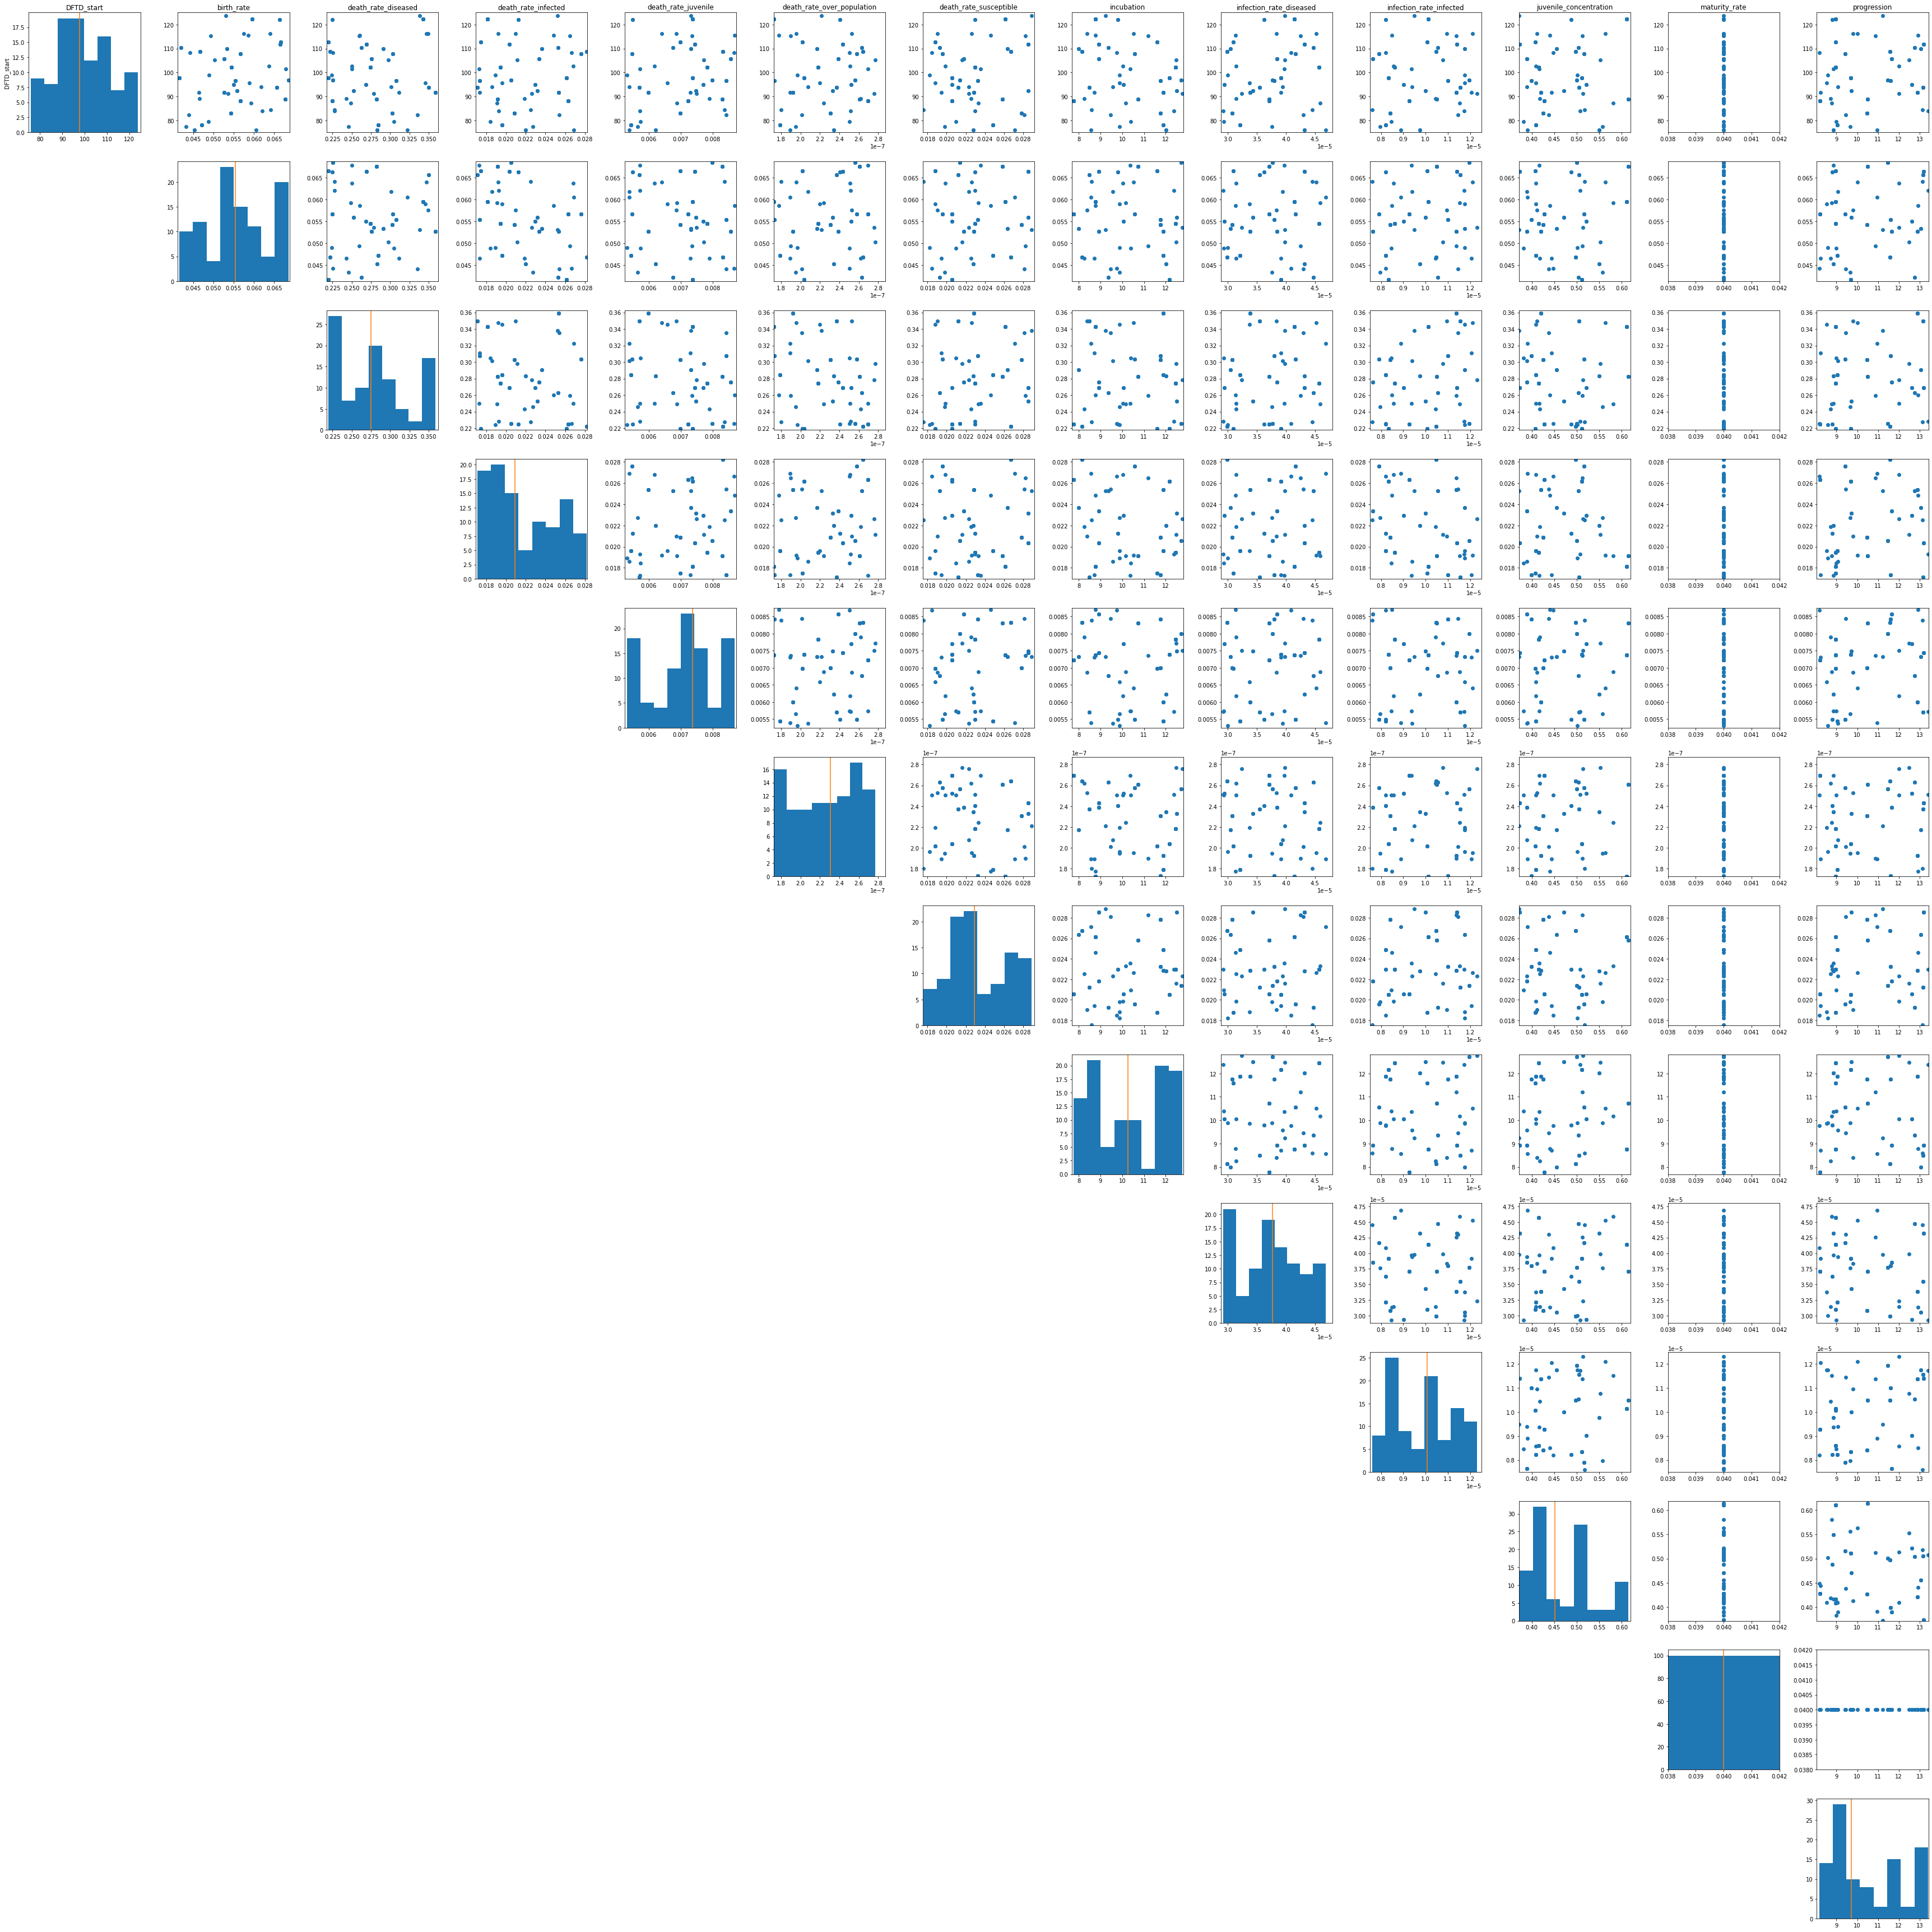

In [12]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
print('Left to Right:')
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(np.exp(posterior[:,i]), bins = 'auto')
                ax[i,j].axvline(np.median(np.exp(posterior[:,i])), color = 'C1')
                ax[i,j].set_xlim(np.exp(dmin[i]), np.exp(dmax[i]))
            else:
                ax[i,j].scatter(np.exp(posterior[:,j]), np.exp(posterior[:,i]))
                ax[i,j].set_ylim(np.exp(dmin[i]), np.exp(dmax[i]))
                ax[i,j].set_xlim(np.exp(dmin[j]), np.exp(dmax[j]))
    print('{}: {}'.format(i, parameter_names[i]))
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(48,48)
plt.savefig('devil-param-correlation-vanilla.png')
with open('fig-obj-vanilla.p', 'wb') as fig_obj_file:
    pickle.dump(fig, fig_obj_file)
with open('posterior-data-vanilla.p', 'wb') as posterior_data_file:
    pickle.dump(posterior, posterior_data_file)
fig.tight_layout()

In [13]:
best_ind = np.argmin(res['distances'])

In [14]:
res['distances'][best_ind]

5066517.496101626

In [15]:
print(posterior[best_ind])

[  4.68039045  -2.87029467  -1.19197078  -3.59032523  -5.20583134
 -15.17130714  -3.93280307   2.35752934 -10.08666053 -11.74807451
  -0.6620831   -3.21887582   2.24380172]


In [16]:
solver = TauHybridCSolver(model=model)

{'DFTD_start': 107.81215956881644, 'birth_rate': 0.056682221708120394, 'death_rate_diseased': 0.3036223003243304, 'death_rate_infected': 0.027589356091550683, 'death_rate_juvenile': 0.005484489092454015, 'death_rate_over_population': 2.5774189983571154e-07, 'death_rate_susceptible': 0.01958868712535015, 'incubation': 10.564817086331837, 'infection_rate_diseased': 4.163120574608661e-05, 'infection_rate_infected': 7.904530303623121e-06, 'juvenile_concentration': 0.5157758046545342, 'maturity_rate': 0.04000000000000001, 'progression': 9.429110057610297}


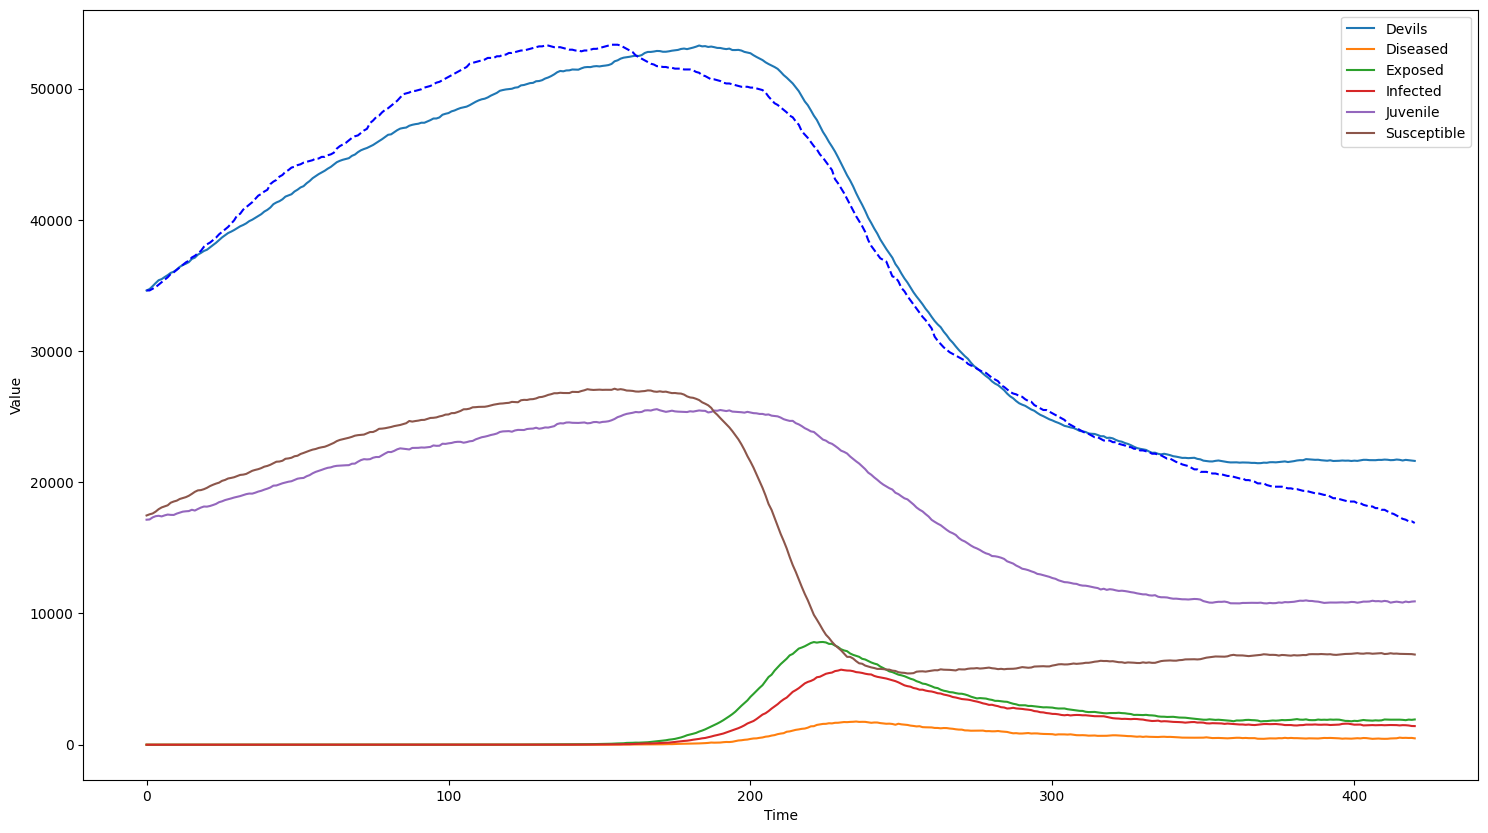

In [17]:
selected_vars = dict(zip(parameter_names, np.exp(posterior[best_ind])))
print(selected_vars)
test = model.run(solver=solver, variables=selected_vars)

test.plot()
plt.plot(total_time, devil_pop, '--b')